# CEDA Open DAP Access

In [2]:
from netCDF4 import Dataset
url = "http://dap.ceda.ac.uk/thredds/dodsC/badc/ukcp18/data/marine-sim/skew-trend/rcp85/skewSurgeTrend/latest/skewSurgeTrend_marine-sim_rcp85_trend_2007-2099.nc"
ds = Dataset(url)

We need to get a certificate for data access, source for this code: https://github.com/cedadev/opendap-python-example/blob/master/remote_nc_reader.py

In [5]:
import os
import datetime
from getpass import getpass


# Import third-party libraries
from cryptography import x509
from cryptography.hazmat.backends import default_backend

from contrail.security.onlineca.client import OnlineCaClient

# Credentials defaults
DODS_FILE_CONTENTS = """HTTP.COOKIEJAR=./dods_cookies
HTTP.SSL.CERTIFICATE=./credentials.pem
HTTP.SSL.KEY=./credentials.pem
HTTP.SSL.CAPATH=./ca-trustroots
"""

DODS_FILE_PATH = os.path.expanduser('~/.dodsrc')
CERTS_DIR = os.path.expanduser('~/.certs')

if not os.path.isdir(CERTS_DIR):
    os.makedirs(CERTS_DIR)

TRUSTROOTS_DIR = os.path.join(CERTS_DIR, 'ca-trustroots')
CREDENTIALS_FILE_PATH = os.path.join(CERTS_DIR, 'credentials.pem')

TRUSTROOTS_SERVICE = 'https://slcs.ceda.ac.uk/onlineca/trustroots/'
CERT_SERVICE = 'https://slcs.ceda.ac.uk/onlineca/certificate/'


def write_dods_file_contents():

    DODS_FILE_CONTENTS = """
    HTTP.COOKIEJAR=./dods_cookies
    HTTP.SSL.CERTIFICATE={credentials_file_path}
    HTTP.SSL.KEY={credentials_file_path}
    HTTP.SSL.CAPATH={trustroots_dir}
    """.format(credentials_file_path=CREDENTIALS_FILE_PATH, trustroots_dir=TRUSTROOTS_DIR)

    with open(DODS_FILE_PATH, 'w') as dods_file:
        dods_file.write(DODS_FILE_CONTENTS)


def cert_is_valid(cert_file, min_lifetime=0):
    """
    Returns boolean - True if the certificate is in date.
    Optional argument min_lifetime is the number of seconds
    which must remain.
    :param cert_file: certificate file path.
    :param min_lifetime: minimum lifetime (seconds)
    :return: boolean
    """
    try:
        with open(cert_file, 'rb') as f:
            crt_data = f.read()
    except IOError:
        return False

    try:
        cert = x509.load_pem_x509_certificate(crt_data, default_backend())
    except ValueError:
        return False

    now = datetime.datetime.now()

    return (cert.not_valid_before <= now
            and cert.not_valid_after > now + datetime.timedelta(0, min_lifetime))
    

    
def setup_credentials(force=False):
    """
    Download and create required credentials files.
    Return True if credentials were set up.
    Return False is credentials were already set up.
    :param force: boolean
    :return: boolean
    """
    # Test for DODS_FILE and only re-get credentials if it doesn't
    # exist AND `force` is True AND certificate is in-date.
    if os.path.isfile(DODS_FILE_PATH) and not force and cert_is_valid(CREDENTIALS_FILE_PATH):
        print('[INFO] Security credentials already set up.')
        return False

    onlineca_client = OnlineCaClient()
    onlineca_client.ca_cert_dir = TRUSTROOTS_DIR

    # Set up trust roots
    trustroots = onlineca_client.get_trustroots(
        TRUSTROOTS_SERVICE,
        bootstrap=True,
        write_to_ca_cert_dir=True)
    
    username = input("CEDA username")#os.environ['CEDA_USERNAME']
    password = getpass("CEDA password")#os.environ['CEDA_PASSWORD']

    # Write certificate credentials file
    key_pair, certs = onlineca_client.get_certificate(
        username,
        password,
        CERT_SERVICE,
        pem_out_filepath=CREDENTIALS_FILE_PATH)

    # Write the dodsrc credentials file
    write_dods_file_contents()

    print('[INFO] Security credentials set up.')
    return True


In [7]:
setup_credentials(force=True)

/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'slcs.ceda.ac.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


CEDA username lbuntemeyer
CEDA password ··········


[INFO] Security credentials set up.


True

In [8]:
ds = Dataset(url)

In [9]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    ModelNames: CNRM-CERFACS-CNRM-CM5 ICHEC-EC-EARTH IPSL-IPSL-CM5A-MR MOHC-HadGEM2-ES MPI-M-MPI-ESM-LR
    collection: marine-sim
    contact: ukcpproject@metoffice.gov.uk
    domain: uk
    institution: Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, Devon, EX1 3PB, UK.
    institution_id: MOHC
    project: UKCP18
    scenario: rcp85
    source: Atmospheric storminess data from five CMIP5 models  is downscaled by the Swedish Meteorological and Hydrological Institute regional climate model RCA4 and used to drive the National Oceanography Centre/Met Office storm surge model CS3. The 5 largest skew surges in each year are identified and a 4-parameter joint probability distribution (including a linear trend in location parameter over time) is fitted. The data given here are the trends in the location parameter from 2007 to 2099. Mean sea level change is NOT included. By construction the s

In [3]:
cru_tmp_url = "http://dap.ceda.ac.uk/thredds/dodsC/badc/cru/data/cru_ts/cru_ts_4.03/data/tmp/cru_ts4.03.1901.2018.tmp.dat.nc"

In [4]:
import xarray as xr
cru_tmp_ds = xr.open_dataset(cru_tmp_url)

In [5]:
cru_tmp_ds.time

<xarray.DataArray 'time' (time: 1416)>
array(['1901-01-16T00:00:00.000000000', '1901-02-15T00:00:00.000000000',
       '1901-03-16T00:00:00.000000000', ..., '2018-10-16T00:00:00.000000000',
       '2018-11-16T00:00:00.000000000', '2018-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2018-12-16
Attributes:
    long_name:  time

In [6]:
!ls /work/ik1017/Catalogs/

archive		      mistral-miklip.csv.gz  mistral-MPI-GE.json
mistral-cmip6.csv.gz  mistral-miklip.json    ncar-intake-esm-datastore
mistral-cmip6.json    mistral-MPI-GE.csv.gz  pangeo-cmip6.json


In [7]:
!ls /work/kd0956/Catalogs/

archive		      mistral-cmip5.json~    mistral-era5.csv.gz
mistral-cmip5.csv.gz  mistral-cordex.csv.gz  mistral-era5.json
mistral-cmip5.json    mistral-cordex.json


In [8]:
dkrz_cordex_catalog_url = "/work/kd0956/Catalogs/mistral-cordex.json"

In [9]:
import intake
catalog = intake.open_esm_datastore(dkrz_cordex_catalog_url)

In [10]:
catalog

,unique
product_id,2
CORDEX_domain,23
institute_id,67
driving_model_id,13
experiment_id,5
member,5
model_id,26
rcm_version_id,5
frequency,7
variable_id,101


In [11]:
attrs = {'CORDEX_domain' : 'EUR-11', 'variable_id' : 'tas', 'experiment_id' : 'historical',
        'model_id': 'GERICS-REMO2015', 'frequency': 'mon'}

In [12]:
selection = catalog.search(**attrs)

In [13]:
selection

,unique
product_id,1
CORDEX_domain,1
institute_id,2
driving_model_id,4
experiment_id,1
member,2
model_id,1
rcm_version_id,1
frequency,1
variable_id,1


In [14]:
selection.df.driving_model_id.unique()

array(['MPI-M-MPI-ESM-LR', 'IPSL-IPSL-CM5A-LR', 'NOAA-GFDL-GFDL-ESM2G',
       'NCC-NorESM1-M'], dtype=object)

In [18]:
dsets = selection.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency'


In [19]:
dsets.keys()

dict_keys(['EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.MPI-M-MPI-ESM-LR.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.NCC-NorESM1-M.z_GERICS_KB.GERICS-REMO2015.historical.mon', 'EUR-11.NCC-NorESM1-M.GERICS.GERICS-REMO2015.historical.mon', 'EUR-11.IPSL-IPSL-CM5A-LR.GERICS.GERICS-REMO2015.historical.mon'])

In [20]:
files = list(selection.df.groupby('driving_model_id').get_group('MPI-M-MPI-ESM-LR').path)
files.sort()
files

['/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_195002-195012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_195101-196012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_196101-197012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/tas_EUR-11_MPI-M-MPI-ESM-LR_historical_r3i1p1_GERICS-REMO2015_v1_mon_197101-198012.nc',
 '/mnt/lustre01/work/kd0956/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/his

In [21]:
remo_tas_mpi_esm_ds = xr.open_mfdataset(files)

In [22]:
# this wont work because files are not sorted in the catalog by default
#remo_tas_mpi_esm_ds = dsets['EUR-11.NOAA-GFDL-GFDL-ESM2G.GERICS.GERICS-REMO2015.historical.mon']
remo_tas_mpi_esm_ds.time

<xarray.DataArray 'time' (time: 671)>
array(['1950-02-15T00:00:00.000000000', '1950-03-16T12:00:00.000000000',
       '1950-04-16T00:00:00.000000000', ..., '2005-10-16T12:00:00.000000000',
       '2005-11-16T00:00:00.000000000', '2005-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-02-15 ... 2005-12-16T12:00:00
    height   float64 2.0
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [71]:
cru_tas_hist = cru_tmp_ds.sel(time=slice("2000-01-01", "2000-01-31"))
cru_tas_hist

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1)
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 2000-01-16
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.4
    title:                           CRU TS4.03 Mean Temperature
    institution:                     Data held at British Atmospheric Data Ce...
    source:                          Run ID = 1905011326. Data generated from...
    history:                         Wed  1 May 2019 15:42:51 BST : User ianh...
    references:                      Information on the data is available at ...
    comment:                         Access to these data is available to any...
    contact:                         support@ceda.ac.uk
    DODS_EXTRA.Unlimited_Dimension:  time

In [24]:
remo_tas_hist = remo_tas_mpi_esm_ds.sel(time=slice("2000-01-01", "2000-01-31"))

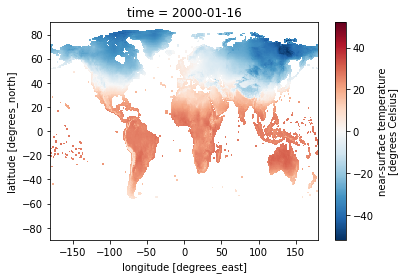

In [25]:
cru_tas_hist.tmp.plot()

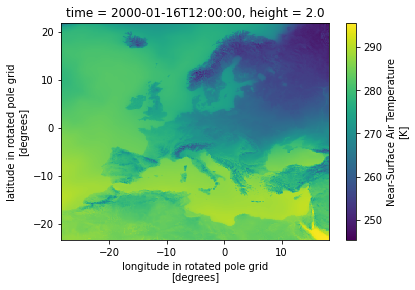

In [47]:
remo_tas_hist.tas.plot()

In [48]:

plot = remo_tas_hist.tas.isel(time=0).plot.contour('lon','lat', 
                                         levels=12, cmap = 'RdBu_r',vmax = 99000, ax=ax);

/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


In [52]:
remo_tas_hist

<xarray.Dataset>
Dimensions:                     (bnds: 2, rlat: 412, rlon: 424, time: 1, vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 2000-01-16T12:00:00
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    height                      float64 2.0
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647
    lat_vertices                (time, rlat, rlon, vertices) float32 dask.array<chunksize=(1, 412, 424, 4), meta=np.ndarray>
    lon_vertices                (time, rlat, rlon, vertices) float32 dask.array<chunksize=(1, 412, 424, 4), meta=np.ndarray>
    tas                         (time, rlat, rlon) float32 dask.array<chunksize=(1, 412, 424), meta=np.ndarray>
Attributes:
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  historical
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    parent_experiment_id:           N/A
    parent_experiment_rip:          N/A
    branch_time:                    0.0
    contact:                        gerics-cordex@hzg.de
    history:                        There is no special history for this expe...
    comment:                        CORDEX Europe RCM REMO EUR-11. Data_polic...
    references:                     http://www.remo-rcm.de
    initialization_method:          1
    physics_version:                1
    CORDEX_domain:                  EUR-11
    driving_experiment:             MPI-M-MPI-ESM-LR, historical, r3i1p1
    driving_model_id:               MPI-M-MPI-ESM-LR
    driving_model_ensemble_member:  r3i1p1
    driving_experiment_name:        historical
    rcm_version_id:                 v1
    product:                        output
    experiment:                     historical
    frequency:                      mon
    creation_date:                  2019-06-19T15:44:26Z
    Conventions:                    CF-1.4
    project_id:                     CORDEX
    table_id:                       Table mon (Mar 2015) c0a10bad89df35dfced7...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    3
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/7e847054-073c-46be-9fd4-606d...

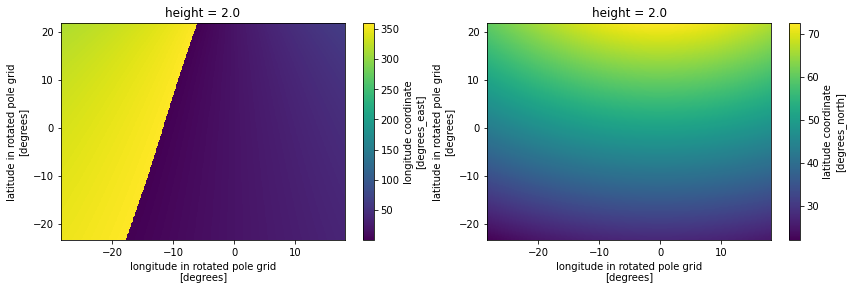

In [28]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
remo_tas_hist.lon.plot(ax=ax1)
remo_tas_hist.lat.plot(ax=ax2)



/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


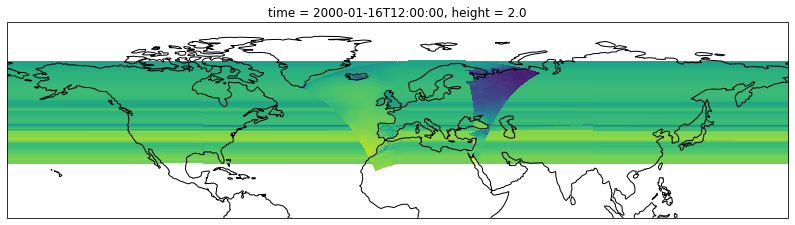

In [53]:
import cartopy.crs as ccrs
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
remo_tas_hist.tas[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);

In [56]:
pole = remo_tas_hist.rotated_latitude_longitude
pole

<xarray.DataArray 'rotated_latitude_longitude' (time: 1)>
array([-2147483647], dtype=int32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16T12:00:00
    height   float64 2.0
Attributes:
    grid_mapping_name:          rotated_latitude_longitude
    grid_north_pole_latitude:   39.25
    grid_north_pole_longitude:  -162.0
    north_pole_grid_longitude:  0.0

In [58]:
rotated_pole = ccrs.RotatedPole(pole_latitude=pole.grid_north_pole_latitude, pole_longitude=pole.grid_north_pole_longitude)
rotated_pole

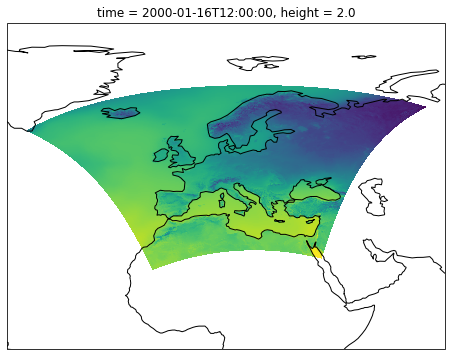

In [65]:
import cartopy.crs as ccrs
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
remo_tas_hist.tas[0].plot.pcolormesh(ax=ax, transform=rotated_pole, add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);

In [69]:
import xesmf as xe
# https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html?highlight=rotated%20poleregridder = xe.Regridder(ds, ds_out, 'bilinear')

In [72]:
regridder = xe.Regridder(cru_tas_hist, remo_tas_hist, 'bilinear')

In [73]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x720_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 720) 
Output grid shape:          (412, 424) 
Output grid dimension name: ('rlat', 'rlon') 
Periodic in longitude?      False

In [74]:
cru_regrid = regridder(cru_tas_hist.tmp)

/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/xesmf/frontend.py:459: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [133]:
cru_regrid['rlon'] = remo_tas_hist.rlon
cru_regrid['rlat'] = remo_tas_hist.rlat
cru_regrid

<xarray.DataArray 'tmp' (time: 1, rlat: 412, rlon: 424)>
array([[[ 19.2653435 ,  19.21751514,  19.17617136, ...,          nan,
                  nan,          nan],
        [ 19.13565617,  19.0943731 ,  19.05959762, ...,          nan,
                  nan,          nan],
        [ 18.99834755,  18.96362445,  18.96146665, ...,          nan,
                  nan,          nan],
        ...,
        [ -5.86641524,  -5.85592898,  -5.81752951, ..., -27.89350016,
         -27.60032936, -27.25049372],
        [ -5.73735352,  -5.92511573,  -6.08674205, ..., -28.35511819,
         -28.00497258, -27.65300313],
        [ -5.57852237,  -5.8709236 ,  -6.41085725, ..., -28.27102203,
         -28.3956749 , -28.07885674]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16
    lon      (rlat, rlon) float32 349.9361 350.03607 ... 64.75965 64.96463
    lat      (rlat, rlon) float32 21.987913 22.027924 ... 66.75225 66.690094
    height   float64 2.0
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.93 18.04 18.16
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.61 21.72 21.84
Attributes:
    regrid_method:  bilinear

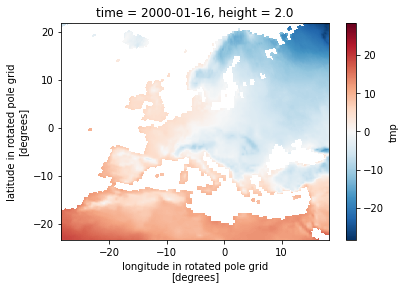

In [134]:
cru_regrid.plot()

In [135]:
remo_tas_hist.tas

<xarray.DataArray 'tas' (time: 1, rlat: 412, rlon: 424)>
dask.array<getitem, shape=(1, 412, 424), dtype=float32, chunksize=(1, 412, 424), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16T12:00:00
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.61 21.72 21.84
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.93 18.04 18.16
    lat      (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon      (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    height   float64 2.0
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             K
    original_name:     tas
    cell_methods:      time: mean
    history:           2019-06-19T15:44:26Z altered by CMOR: Treated scalar d...
    associated_files:  gridspecFile: gridspec_atmos_fx_GERICS-REMO2015_histor...
    grid_mapping:      rotated_latitude_longitude

In [146]:
cru_regrid

<xarray.DataArray 'tmp' (time: 1, rlat: 412, rlon: 424)>
array([[[ 19.2653435 ,  19.21751514,  19.17617136, ...,          nan,
                  nan,          nan],
        [ 19.13565617,  19.0943731 ,  19.05959762, ...,          nan,
                  nan,          nan],
        [ 18.99834755,  18.96362445,  18.96146665, ...,          nan,
                  nan,          nan],
        ...,
        [ -5.86641524,  -5.85592898,  -5.81752951, ..., -27.89350016,
         -27.60032936, -27.25049372],
        [ -5.73735352,  -5.92511573,  -6.08674205, ..., -28.35511819,
         -28.00497258, -27.65300313],
        [ -5.57852237,  -5.8709236 ,  -6.41085725, ..., -28.27102203,
         -28.3956749 , -28.07885674]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16
    lon      (rlat, rlon) float32 349.9361 350.03607 ... 64.75965 64.96463
    lat      (rlat, rlon) float32 21.987913 22.027924 ... 66.75225 66.690094
    height   float64 2.0
  * rlon     (rlon) float64 -28.38 -28.27 -28.16 -28.05 ... 17.93 18.04 18.16
  * rlat     (rlat) float64 -23.38 -23.27 -23.16 -23.05 ... 21.61 21.72 21.84
Attributes:
    regrid_method:  bilinear

In [147]:
diff = remo_tas_hist.tas[0] - cru_regrid[0] - 273.5

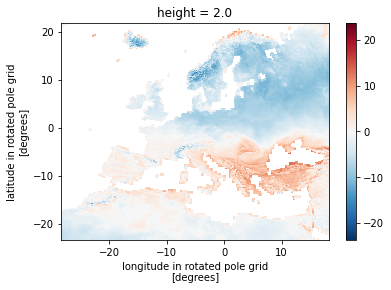

In [149]:
diff.plot()